In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from eegatscale.models import LinearHeadBENDR
from eegatscale.transforms import Standardize
from scipy.stats import ttest_ind
import torch

from captum.concept import TCAV, Concept
from captum.attr import IntegratedGradients, LayerIntegratedGradients
from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str
import warnings
# warnings.filterwarnings("ignore")

In [32]:
transform = Standardize()


In [33]:
concept_dir = "/scratch/s194101/concepts/sanity_check_concepts_MMIDB_alpha"
anatomical_concepts = ["Premotor Cortex", "Somatosensory and Motor Cortex", "Early Visual Cortex", "Primary Visual Cortex (V1)", "Dorsal Stream Visual Cortex"]
band = "Alpha"
hemis = ["lh", "rh"]
def add_band_and_hemi(anatomical_concepts, band, hemis=["lh", "rh"]):
    return [f"{band}_{anatomical_concept}-{hemi}" for anatomical_concept in anatomical_concepts for hemi in hemis]


concept_names = add_band_and_hemi(anatomical_concepts, band, hemis)
concept_names

concepts = []


In [34]:
def get_tensor_from_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # remove last channel
    # batch_size x num_channels x num_timepoints
    data = data[:,:-1,:]
    data = transform(data)
    return torch.tensor(data).squeeze(0)

# make the folder a concept
def assemble_concept(name, id, concepts_path):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_pickle_file, concept_path)
    concept_iter = dataset_to_dataloader(dataset)


    return Concept(name=name, id=id, data_iter=concept_iter)

In [35]:
anatomical_concepts = [assemble_concept(name, id, concept_dir) for id, name in enumerate(concept_names)]

In [36]:
concepts.extend(anatomical_concepts)

### Random concepts

In [37]:

random_dir_mmidb = "/scratch/s194101/concepts"
random_mmidb = assemble_concept("sanity_check_concepts_MMIDB_alpha", 11, random_dir_mmidb)
# random_tuh = assemble_concept("random_tuh_alpha", 10, random_dir_mmidb)

# concepts.extend([random_tuh, random_mmidb])
concepts.extend([random_mmidb])

### Left first concept

In [38]:
left_fist_concept_dir = '/scratch/s194101/concepts'
left_fist_concept = assemble_concept("/scratch/s194101/concepts/random_left_concept_MMIDB_Alpha_sanity_check", 12, left_fist_concept_dir)


concepts.extend([left_fist_concept])

In [40]:
concepts

[Concept(0, 'Alpha_Premotor Cortex-lh'),
 Concept(1, 'Alpha_Premotor Cortex-rh'),
 Concept(2, 'Alpha_Somatosensory and Motor Cortex-lh'),
 Concept(3, 'Alpha_Somatosensory and Motor Cortex-rh'),
 Concept(4, 'Alpha_Early Visual Cortex-lh'),
 Concept(5, 'Alpha_Early Visual Cortex-rh'),
 Concept(6, 'Alpha_Primary Visual Cortex (V1)-lh'),
 Concept(7, 'Alpha_Primary Visual Cortex (V1)-rh'),
 Concept(8, 'Alpha_Dorsal Stream Visual Cortex-lh'),
 Concept(9, 'Alpha_Dorsal Stream Visual Cortex-rh'),
 Concept(11, 'sanity_check_concepts_MMIDB_alpha'),
 Concept(12, '/scratch/s194101/concepts/random_left_concept_MMIDB_Alpha_sanity_check')]

In [39]:
# check if all of them loaded properly
all([len(next(iter(concept.data_iter))) > 0 for concept in concepts])
# concepts

/tmp/ipykernel_3452229/4217126809.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data).squeeze(0)


IsADirectoryError: [Errno 21] Is a directory: '/scratch/s194101/concepts/sanity_check_concepts_MMIDB_alpha/Alpha_Insular and Frontal Opercular Cortex-lh'

## Load finetuned model

In [20]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"
encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt"
# encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_nogroups/version_21/checkpoints/epoch=6-step=1764.ckpt"

model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

Initialized mask embedding and position encoder from  /scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt
model loaded


In [21]:
# try forward pass
x = next(iter(anatomical_concepts[0].data_iter))
assert len(model(x)) > 0

In [23]:
# test model predictive performance
sample_concept = left_fist_concept
x = next(iter(sample_concept.data_iter))
y_pred = model(x).argmax(dim=1).sum()
acc = 1 - y_pred / len(x)
acc


tensor(0.7188)

In [ ]:
# layers = ["encoder", "enc_augment", "summarizer", "extended_classifier", "clf"]
layers = ["encoder", "enc_augment", "summarizer", "extended_classifier"]

tcav = TCAV(
    model=model,
    layers=layers,
    # layer_attr_method=LayerIntegratedGradients(model, None, multiply_by_inputs=False),
)
inputs = next(iter(left_fist_concept.data_iter))

experimental_sets = [
    [anatomical_concepts[0], random_mmidb],
    [anatomical_concepts[1], random_mmidb],
    # [anatomical_concepts[2], random_mmidb],
    # [anatomical_concepts[3], random_mmidb],
    [left_fist_concept, random_mmidb],
    
]
experimental_sets


all_experimental_sets = [
    [
    [anatomical_concepts[0], random_mmidb],    
    ],  
    [
    [anatomical_concepts[1], random_mmidb],    
    ],  
    # [
    # [anatomical_concepts[2], random_mmidb],    
    # ],  
    # [
    # [anatomical_concepts[3], random_mmidb],    
    # ],  
    [
    [left_fist_concept, random_mmidb],    
    ],  
]

all_tcav_scores = []
for temp_experimental_set in all_experimental_sets:
    print(temp_experimental_set)
    tcav_scores = tcav.interpret(inputs=inputs, experimental_sets=temp_experimental_set, target=0)
    all_tcav_scores.append(tcav_scores)

[[Concept(0, 'Alpha_Premotor Cortex-lh'), Concept(11, 'random_mmidb')]]
[[Concept(1, 'Alpha_Premotor Cortex-rh'), Concept(11, 'random_mmidb')]]
[[Concept(12, 'random_left_concept_MMIDB'), Concept(11, 'random_mmidb')]]


In [194]:
tcav_scores = tcav.interpret(inputs=inputs, experimental_sets=experimental_sets, target=0)
tcav_scores = dict(tcav_scores)
tcav_scores

{'0-11': defaultdict(None,
             {'encoder': {'sign_count': tensor([1., 0.]),
               'magnitude': tensor([ 0.0701, -0.0701])},
              'enc_augment': {'sign_count': tensor([0.3200, 0.6800]),
               'magnitude': tensor([-0.1560,  0.1560])},
              'summarizer': {'sign_count': tensor([0.2000, 0.8000]),
               'magnitude': tensor([-0.2670,  0.2670])},
              'extended_classifier': {'sign_count': tensor([0., 1.]),
               'magnitude': tensor([-0.2719,  0.2719])}}),
 '1-11': defaultdict(None,
             {'encoder': {'sign_count': tensor([1., 0.]),
               'magnitude': tensor([ 0.1815, -0.1815])},
              'enc_augment': {'sign_count': tensor([1., 0.]),
               'magnitude': tensor([ 0.5471, -0.5471])},
              'summarizer': {'sign_count': tensor([1., 0.]),
               'magnitude': tensor([ 1.7136, -1.7136])},
              'extended_classifier': {'sign_count': tensor([1., 0.]),
               'magnitude':

In [195]:
# stats = {}
# for cav_key in tcav.cavs.keys():
#         exp_stats = {}
#         for layer_key in tcav.cavs[cav_key].keys():
#             exp_stats[layer_key] = {"concepts": tcav.cavs[cav_key][layer_key].concepts,
#                                     "layer": tcav.cavs[cav_key][layer_key].layer,
#                                     "stats": {"classes": tcav.cavs[cav_key][layer_key].stats["classes"],
#                                               "accs": tcav.cavs[cav_key][layer_key].stats["accs"]}}
#         stats[cav_key] = exp_stats

In [196]:
# stats

In [197]:
result_path_tmp = "tcav_result.pkl"

with open(result_path_tmp, 'wb') as f:
    pickle.dump({"experimental_sets": experimental_sets,
                     "tcav_scores": tcav_scores,
                     "stats": stats}, f)

In [198]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            # val = [format_float(scores['magnitude'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

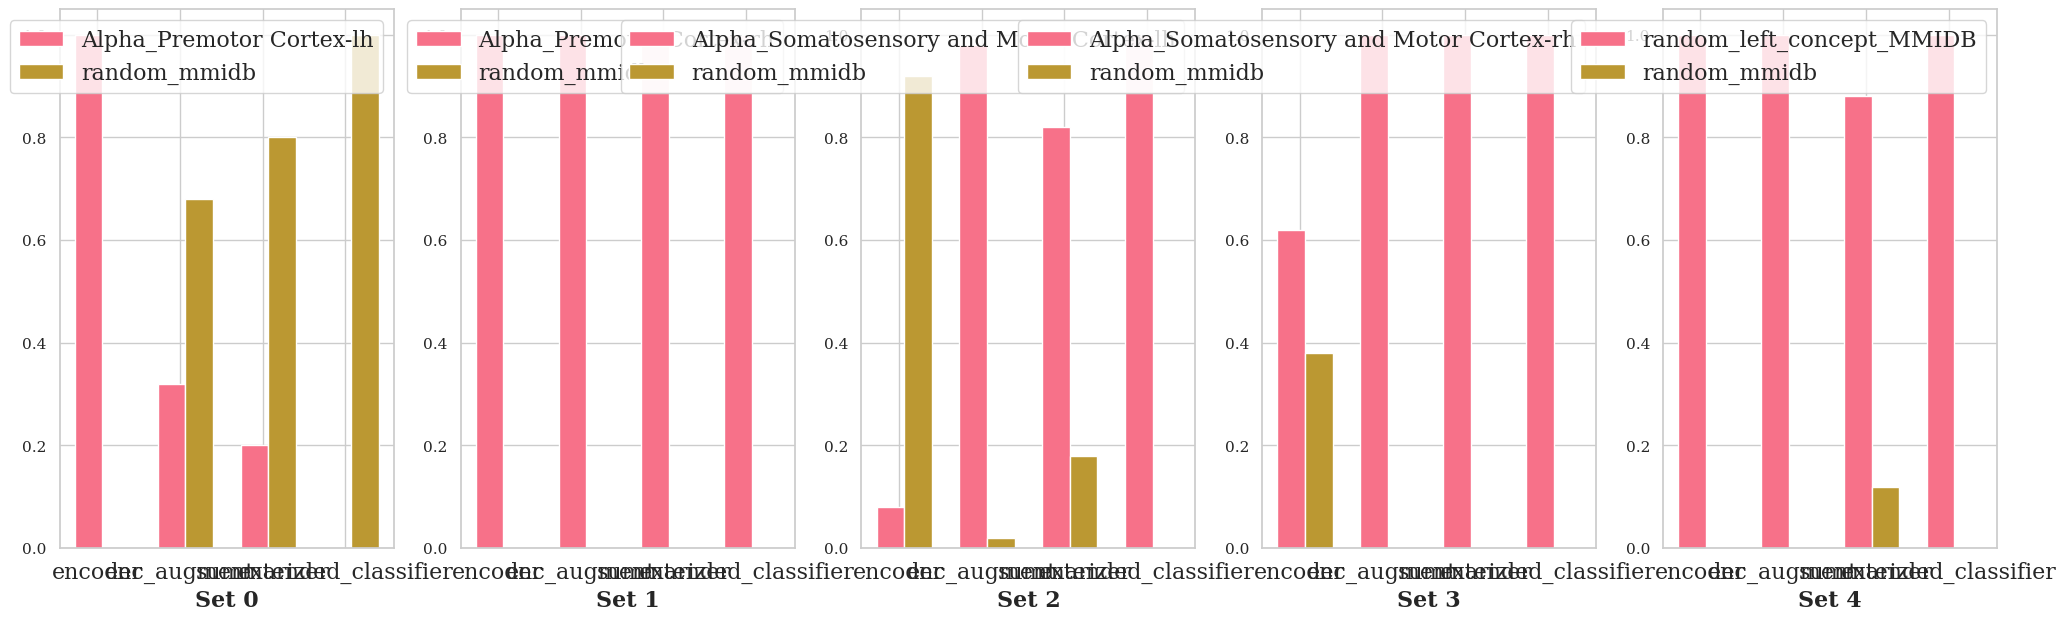

In [199]:
plot_tcav_scores(experimental_sets, tcav_scores)

In [200]:
with open(result_path_tmp, 'rb') as f:
    data = pickle.load(f)

In [201]:
experimental_sets = data["experimental_sets"]
tcav_scores = data["tcav_scores"]
stats = data["stats"]

In [202]:
def assemble_scores(tcav_scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(tcav_scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
    score_list = np.array(score_list)
    return score_list

In [203]:
p1 = assemble_scores(tcav_scores, experimental_sets, 0, "encoder", "sign_count")
p2 = assemble_scores(tcav_scores, experimental_sets, 1, "encoder", "sign_count")

ttest_ind(p1, p2)

TtestResult(statistic=1.878672637841706, pvalue=0.09710355903051414, df=8.0)

In [204]:
from matplotlib.container import BarContainer

def plot_tcav_scores(all_experimental_sets, all_tcav_scores, score_type="sign_count", alpha=0.05, only_significant=True,
                     with_error=True, plt_name="plot", file_type="svg"):
    tcav_score0 = next(iter(all_tcav_scores[0].values()))
    layers = list(tcav_score0.keys())
    scores_mean = {layer: [] for layer in layers}
    scores_std = {layer: [] for layer in layers}
    stars = {layer: [] for layer in layers}
    concept_short_names = []
    for experimental_sets, tcav_scores in zip(all_experimental_sets, all_tcav_scores):
        concept_short_codes = [int(str(concept.id)[:5]) for concept in experimental_sets[0]]
        concept_short_names_next = [concept.name[:-4] for concept in experimental_sets[0]]
        concept_short_names.append(concept_short_names_next[0])

        for layer in layers:
            pos_scores = assemble_scores(tcav_scores, experimental_sets, 0, layer, score_type)
            neg_scores = assemble_scores(tcav_scores, experimental_sets, 1, layer, score_type)
            # t-test
            _, pval = ttest_ind(pos_scores, neg_scores)
            # Bonferroni correction
            m = 2
            alpha = alpha / m
            # Get non-significant and significant scores
            not_significant = np.mean(pos_scores) < np.mean(neg_scores) or pval >= alpha
            stars[layer].append(not_significant)
            if not_significant and only_significant:
                scores_mean[layer].append(0.0)
                scores_std[layer].append(0.0)
            else:
                scores_mean[layer].append(np.mean(pos_scores))
                scores_std[layer].append(np.std(pos_scores))
    scores_mean_df = pd.DataFrame(data=scores_mean, index=concept_short_names)
    scores_std_df = pd.DataFrame(data=scores_std, index=concept_short_names)

    fig = plt.figure(figsize=(10, 3))
    ax = plt.subplot()
    if with_error:
        scores_mean_df.plot.bar(ax=ax, rot=0, yerr=scores_std_df)
    else:
        scores_mean_df.plot.bar(ax=ax, rot=0)

    containers = []
    for container in ax.containers:
        if isinstance(container, BarContainer):
            containers.append(container)
    for container, star in zip(containers, stars.values()):
        labels = []
        for s_idx, s in enumerate(star):
            if s:
                labels.append("*")
                current_color = container.patches[s_idx].get_facecolor()
                new_color = current_color
                # new_color = [c for c in current_color[:-1]]
                # new_color.append(0.25)
                container.patches[s_idx].set_facecolor(new_color)
            else:
                labels.append("")
        ax.bar_label(container, labels=labels, size=18, color=container.patches[0].get_facecolor())
    ax.set_ylim(bottom=0.0, top=1.0)

    ax.set_ylabel("TCAV score")
    ax.legend(loc="upper right", title="Network layer")

    plt.tight_layout()
    plt.show()
    plt.savefig(f"{plt_name}.{file_type}")
    plt.close()

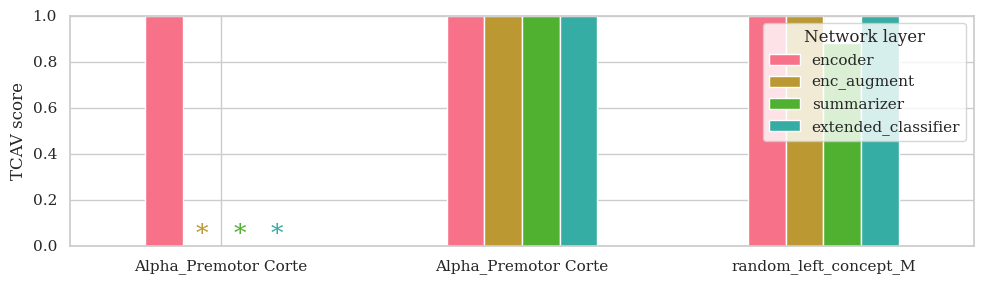

In [205]:
plot_tcav_scores(all_experimental_sets, all_tcav_scores, score_type="sign_count", alpha=0.05, only_significant=True, with_error=True, plt_name="plot", file_type="png")